In [1]:
import matplotlib
import numpy as np
import pandas as pd
from numerapi import NumerAPI
import random
import sklearn
import lightgbm
import matplotlib.pyplot as plt
from utils import save_model, load_model, neutralize, get_biggest_change_features, validation_metrics, download_data
%matplotlib inline

from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm
)

#pandas.options.display.max_rows=1000
#pandas.options.display.max_columns=300

In [2]:
napi = NumerAPI()

current_round = napi.get_current_round()

# read in all of the new datas
# tournament data and example predictions change every week so we specify the round in their names
# training and validation data only change periodically, so no need to download them over again every single week
napi.download_dataset("numerai_training_data.parquet")
df = pd.read_parquet('numerai_training_data.parquet')
df.head()

✔ Downloading numerai_training_data.parquet⠙ Downloading numerai_training_data.parquet⠹ Downloading numerai_training_data.parquet⠸ Downloading numerai_training_data.parquet⠼ Downloading numerai_training_data.parquet Downloading numerai_training_data.parquet


,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,...,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,1.0,0.50,1.00,1.00,0.00,0.00,1.00,1.00,...,0.25,0.25,0.25,0.00,0.166667,0.000000,0.166667,0.000000,0.166667,0.000000
n003bee128c2fcfc,0001,train,0.5,1.00,0.25,0.75,0.00,0.75,0.50,0.75,...,1.00,1.00,1.00,1.00,0.833333,0.666667,0.833333,0.666667,0.833333,0.666667
n0048ac83aff7194,0001,train,0.5,0.25,0.75,0.00,0.75,0.00,0.75,0.75,...,0.50,0.25,0.25,0.25,0.500000,0.333333,0.500000,0.333333,0.500000,0.333333
n00691bec80d3e02,0001,train,1.0,0.50,0.50,0.75,0.00,1.00,0.25,1.00,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n00b8720a2fdc4f2,0001,train,1.0,0.75,1.00,1.00,0.00,0.00,1.00,0.50,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000


In [3]:
# There are 2412105 rows grouped into 574 weekly eras
df.shape

(2412105, 1073)

In [4]:
# There's 1050 features with fun names generated by a hashing function
features = [c for c in df if c.startswith("feature")]
df["erano"] = df.era.astype(int)
eras = df.erano
target = "target"
print(len(features))
print(features[:5])

1050
['feature_dichasial_hammier_spawner', 'feature_rheumy_epistemic_prancer', 'feature_pert_performative_hormuz', 'feature_hillier_unpitied_theobromine', 'feature_perigean_bewitching_thruster']


# There are now 20 targets!

## There are 10 different types of targets constructed and 2 versions of each constructed with a 20 day window or a 60 day window
## You are only scored on 'target' which currently corresponds to 'target_nomi_20' but could change in the future
## The other  auxillary targets can be very useful for training good models. Indeed you may find that a model trained on some of the auxillary targets generalize out-of-sample to 'target' better than a model trained on 'target'

In [5]:
target = "target"
targets = [c for c in df if c.startswith("target")]
len(targets)

21

In [6]:
# The targets have a wide range of correlations with each other from ~0.3 to ~0.9
# This should allow the construction of many diverse models which ensemble nicely
df[targets].corr()

,target,target_nomi_20,target_nomi_60,target_jerome_20,target_jerome_60,target_janet_20,target_janet_60,target_ben_20,target_ben_60,target_alan_20,...,target_paul_20,target_paul_60,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60
target,1.000000,1.000000,0.503147,0.769365,0.455448,0.659012,0.392255,0.819540,0.455063,0.678464,...,0.751827,0.441127,0.722665,0.401227,0.819724,0.484425,0.829850,0.490358,0.880602,0.486349
target_nomi_20,1.000000,1.000000,0.503147,0.769365,0.455448,0.659012,0.392255,0.819540,0.455063,0.678464,...,0.751827,0.441127,0.722665,0.401227,0.819724,0.484425,0.829850,0.490358,0.880602,0.486349
target_nomi_60,0.503147,0.503147,1.000000,0.433388,0.817732,0.373979,0.689912,0.456754,0.813261,0.384636,...,0.423820,0.791360,0.409423,0.705469,0.464266,0.873005,0.468459,0.879774,0.492558,0.877989
target_jerome_20,0.769365,0.769365,0.433388,1.000000,0.463756,0.698353,0.382269,0.768737,0.426895,0.628114,...,0.905954,0.446691,0.689335,0.379908,0.865786,0.453824,0.871040,0.457756,0.748965,0.421251
target_jerome_60,0.455448,0.455448,0.817732,0.463756,1.000000,0.382460,0.693168,0.450810,0.821748,0.372656,...,0.451384,0.884963,0.408582,0.719172,0.457941,0.862257,0.459407,0.865918,0.447718,0.789250
target_janet_20,0.659012,0.659012,0.373979,0.698353,0.382460,1.000000,0.422820,0.641273,0.358757,0.718364,...,0.703169,0.370593,0.576267,0.318308,0.724738,0.385911,0.747625,0.395341,0.648114,0.364063
target_janet_60,0.392255,0.392255,0.689912,0.382269,0.693168,0.422820,1.000000,0.378579,0.672070,0.414573,...,0.374259,0.695526,0.341069,0.596787,0.388464,0.720954,0.395379,0.742915,0.386067,0.677794
target_ben_20,0.819540,0.819540,0.456754,0.768737,0.450810,0.641273,0.378579,1.000000,0.485953,0.655087,...,0.745765,0.433137,0.757761,0.418228,0.746513,0.445281,0.755789,0.449744,0.872847,0.476992
target_ben_60,0.455063,0.455063,0.813261,0.426895,0.821748,0.358757,0.672070,0.485953,1.000000,0.373185,...,0.416077,0.786051,0.425653,0.747294,0.424105,0.787089,0.427728,0.795083,0.480622,0.867900
target_alan_20,0.678464,0.678464,0.384636,0.628114,0.372656,0.718364,0.414573,0.655087,0.373185,1.000000,...,0.614438,0.361734,0.581200,0.328936,0.642762,0.381904,0.661255,0.392130,0.702886,0.385541


# 1050 features, no feature groups!

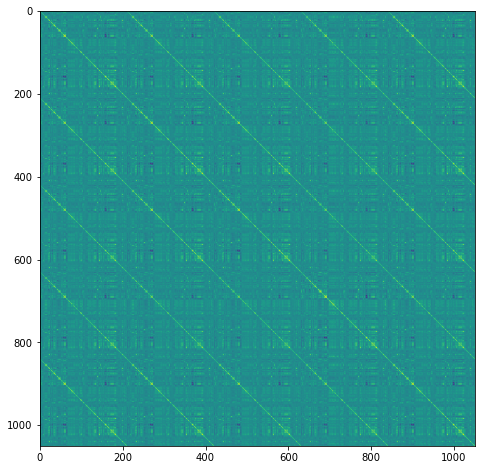

In [7]:
# The features are no longer explicit feature groups, but you can see some pretty obvious patterns if you
# visualize the feature correlation matrix. Feel free to construct your own groupings!
plt.figure(figsize = (8,8))
plt.imshow(df[df.era=='0001'][features].corr())

In [8]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [9]:
# There are 574 eras numbered from 1 to 574
eras.describe()

count    2.412105e+06
mean     3.043023e+02
std      1.598982e+02
min      1.000000e+00
25%      1.720000e+02
50%      3.040000e+02
75%      4.430000e+02
max      5.740000e+02
Name: erano, dtype: float64

<AxesSubplot:xlabel='erano'>

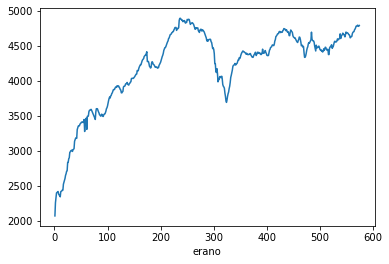

In [10]:
# The earlier eras are smaller, but generally each era is 4000-5000 rows
df.groupby(eras).size().plot()

In [11]:
# The target is discrete and takes on 5 different values with about 5% in 0 & 1, 20% in 0.75 & 0.25, and 50% in 0.50
df.groupby(target).size()/len(df)

target
0.00    0.050003
0.25    0.199996
0.50    0.499993
0.75    0.200015
1.00    0.049992
dtype: float64

In [12]:
# Some new targets have a different distribution and the bins are less rigid in the percent of samples contained
print(df.groupby('target_william_20').size()/len(df))
print()
print(df.groupby('target_arthur_20').size()/len(df))

target_william_20
0.000000    0.029735
0.166667    0.059873
0.333333    0.211150
0.500000    0.391798
0.666667    0.203550
0.833333    0.065247
1.000000    0.038511
dtype: float64

target_arthur_20
0.000000    0.028859
0.166667    0.073267
0.333333    0.258668
0.500000    0.384931
0.666667    0.173287
0.833333    0.052486
1.000000    0.028367
dtype: float64


# Some of the features are very correlated
Some even perfectly correlated within a particular era

In [13]:
feature_corrs = df[df.era=='0001'][features].corr()

In [14]:
feature_corrs.stack().head()

feature_dichasial_hammier_spawner  feature_dichasial_hammier_spawner       1.000000
                                   feature_rheumy_epistemic_prancer        0.001690
                                   feature_pert_performative_hormuz        0.141253
                                   feature_hillier_unpitied_theobromine    0.170891
                                   feature_perigean_bewitching_thruster   -0.151098
dtype: float64

In [15]:
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

feature_calycled_living_birmingham            feature_dentilingual_removed_osmometer             -0.947381
feature_criticisable_authentical_deprecation  feature_invalid_extortionary_titillation           -0.927235
feature_hierologic_assault_candida            feature_multicostate_undescended_monoacid          -0.926623
feature_apogamic_obeisant_pondicherry         feature_splitting_sexagesimal_teutonisation        -0.923430
feature_earthlier_parian_pistachio            feature_grandmotherly_circumnavigable_homonymity   -0.913526
                                                                                                    ...   
feature_escutcheoned_timocratic_kotwal        feature_horizontal_snug_description                 1.000000
                                              feature_neptunian_supersensitive_stapler            1.000000
                                              feature_interoceptive_fifteenth_trey                1.000000
                                     

### The correlation can change over time
You can see this by comparing feature correlations on the first half and second half on the training set

In [16]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [17]:
corr1 = df1[df1.era=='0001'][features].corr().unstack()
corr1 = corr1[corr1.index.get_level_values(0) < corr1.index.get_level_values(1)]

In [18]:
corr2 = df2[df2.era=='0574'][features].corr().unstack()
corr2 = corr2[corr2.index.get_level_values(0) < corr2.index.get_level_values(1)]

In [19]:
tdf = pd.DataFrame({
    "corr1": corr1,
    "corr2": corr2,
})
tdf["corr_diff"] = tdf.corr2 - tdf.corr1
tdf.sort_values(by="corr_diff")

,,corr1,corr2,corr_diff
feature_brushed_psychiatrical_lubbock,feature_savory_engrained_undervest,1.000000,-0.159888,-1.159888
feature_interpenetrative_enabling_elm,feature_savory_engrained_undervest,1.000000,-0.159262,-1.159262
feature_horizontal_snug_description,feature_savory_engrained_undervest,1.000000,-0.158691,-1.158691
feature_abstersive_emotional_misinterpreter,feature_horizontal_snug_description,1.000000,-0.156998,-1.156998
feature_opposable_argumentative_mesoblast,feature_savory_engrained_undervest,1.000000,-0.156654,-1.156654
...,...,...,...,...
feature_descendent_decanal_hon,feature_petitionary_evanescent_diallage,0.128122,0.944659,0.816537
feature_indirect_concrete_canaille,feature_juvenalian_paunchy_uniformitarianism,-0.098432,0.727993,0.826425
feature_draconic_contractible_romper,feature_indirect_concrete_canaille,-0.098432,0.737243,0.835675
feature_bleeding_arabesque_pneuma,feature_instrumentalist_extrovert_cassini,-0.135409,0.720442,0.855851


## Some features are predictive on their own

In [20]:
feature_scores = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][[target]+features].T)[1:,0])}

In [21]:
pd.Series(feature_scores).sort_values()

feature_lofty_acceptable_challenge           -0.082876
feature_unvaried_social_bangkok              -0.082876
feature_undivorced_unsatisfying_praetorium   -0.072182
feature_literate_treacly_altercation         -0.070247
feature_commensurable_industrial_jungfrau    -0.069840
                                                ...   
feature_apomictical_motorized_vaporisation    0.055358
feature_delimited_doable_jim                  0.056142
feature_durative_cuboidal_mirepoix            0.056497
feature_airborne_genitival_cathouse           0.058023
feature_alloyed_copyright_protium             0.059169
Length: 1050, dtype: float64

<AxesSubplot:>

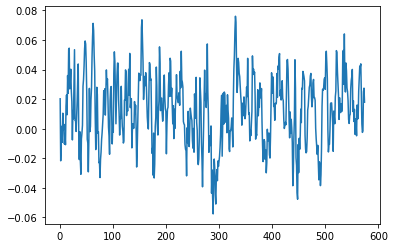

In [22]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf[target], tdf["feature_grandmotherly_circumnavigable_homonymity"])[0,1]
    for era, tdf in df.groupby(eras)
})
by_era_correlation.plot()

<AxesSubplot:>

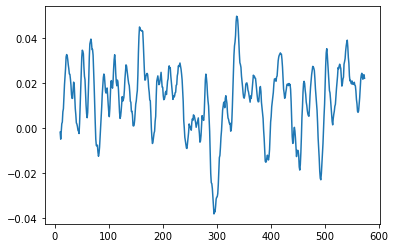

In [23]:
# With a rolling 10 era average you can see some trends
by_era_correlation.rolling(10).mean().plot()

## The feature exposures of different targets can be very different, even orthogonal

In [24]:
feature_scores_nomi20 = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_nomi_20']+features].T)[1:,0])}

In [25]:
feature_scores_nomi60 = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_nomi_60']+features].fillna(0.5).T)[1:,0])}

0.6713159328865955


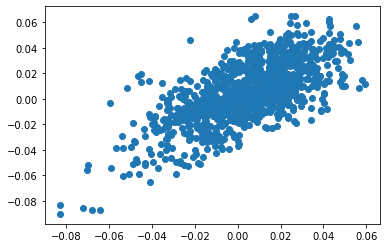

In [26]:
plt.scatter(feature_scores_nomi20.values(), feature_scores_nomi60.values())
print(np.corrcoef(list(feature_scores_nomi20.values()), list(feature_scores_nomi60.values()))[0,1])

In [27]:
feature_scores_jerome = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_jerome_20']+features].T)[1:,0])}

In [28]:
feature_scores_janet = {feature: score for feature, score in zip(features, np.corrcoef(df[df.era=='0001'][['target_janet_20']+features].T)[1:,0])}

0.05603328047427541


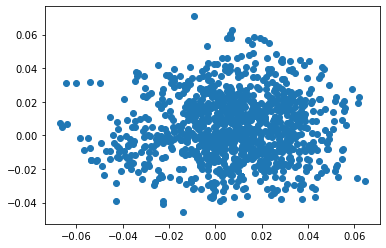

In [29]:
plt.scatter(feature_scores_jerome.values(), feature_scores_janet.values())
print(np.corrcoef(list(feature_scores_jerome.values()), list(feature_scores_janet.values()))[0,1])

# Gotcha: MSE looks worse than correlation out of sample
Models will generally be overconfident, so even if they are good at ranking rows, the Mean-Squared-Error of the residuals could be larger than even the Mean-Squared-Error of the target (r-squared<0)

In [30]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [31]:
linear1 = linear_model.LinearRegression()
linear1.fit(df1[features], df1[target])
linear2 = linear_model.LinearRegression()
linear2.fit(df2[features], df2[target])

LinearRegression()

In [32]:
# Note in particular that the R-squared of (train_on_1, eval_on_2) is slightly negative!
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pd.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.007108,-0.000476
train_on_2,-0.000780,0.006694


In [33]:
# Note in particular that the correlation of (train_on_1, eval_on_2) is quite decent
corrs = [
    [
        numerai_score(dfX[target], pd.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [linear1, linear2]
]
pd.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.081889,0.037630
train_on_2,0.038557,0.078762


In [34]:
# This can be be run with LightGBM as well

In [35]:
lgb1 = lightgbm.LGBMRegressor()
lgb1.fit(df1[features], df1[target])
lgb2 = lightgbm.LGBMRegressor()
lgb2.fit(df2[features], df2[target])

LGBMRegressor()

In [36]:
r2 = [
    [
        model.score(dfX[features], dfX[target])
        for dfX in [df1, df2]
    ]
    for model in [lgb1, lgb2]
]
pd.DataFrame(r2, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.025232,0.002172
train_on_2,0.002142,0.025901


In [37]:
corrs = [
    [
        numerai_score(dfX[target], pd.Series(model.predict(dfX[features]), index=dfX.index))
        for dfX in [df1, df2]
    ]
    for model in [lgb1, lgb2]
]
pd.DataFrame(corrs, columns=["eval_on_1", "eval_on_2"], index=["train_on_1", "train_on_2"])

,eval_on_1,eval_on_2
train_on_1,0.192827,0.047101
train_on_2,0.048331,0.197548


# Gotcha: Eras are now overlapping!

Eras are weekly (5 days), but the target is four weeks out (20 days). You can subsample the eras (every 4th era) to prevent models from overfitting due to overlapping eras. You can then ensemble the models trained on each of the 4 different ways to subsample.

In [38]:
# train model on all eras in df1
lgb_all = lightgbm.LGBMRegressor()
lgb_all.fit(df1[features], df1[target])

LGBMRegressor()

In [39]:
lgb_all.feature_name_

['feature_dichasial_hammier_spawner',
 'feature_rheumy_epistemic_prancer',
 'feature_pert_performative_hormuz',
 'feature_hillier_unpitied_theobromine',
 'feature_perigean_bewitching_thruster',
 'feature_renegade_undomestic_milord',
 'feature_koranic_rude_corf',
 'feature_demisable_expiring_millepede',
 'feature_unscheduled_malignant_shingling',
 'feature_clawed_unwept_adaptability',
 'feature_rubblier_chlorotic_stogy',
 'feature_untumbled_histologic_inion',
 'feature_piffling_inflamed_jupiter',
 'feature_abstersive_emotional_misinterpreter',
 'feature_unluckiest_mulley_benzyl',
 'feature_escutcheoned_timocratic_kotwal',
 'feature_integrated_extroversive_ambivalence',
 'feature_vedic_mitral_swiz',
 'feature_reclaimed_fallibilist_turpentine',
 'feature_gone_honduran_worshipper',
 'feature_insociable_exultant_tatum',
 'feature_outdated_tapered_speciation',
 'feature_leggiest_slaggiest_inez',
 'feature_chaldean_vixenly_propylite',
 'feature_hysteric_mechanized_recklinghausen',
 'feature_g

In [40]:
# train models on subsamples eras in df1
lgb1 = lightgbm.LGBMRegressor()
lgb1.fit(df1[eras.isin(np.arange(1, 304, 4))][features], df1[eras.isin(np.arange(1, 304, 4))][target])

lgb2 = lightgbm.LGBMRegressor()
lgb2.fit(df1[eras.isin(np.arange(2, 304, 4))][features], df1[eras.isin(np.arange(2, 304, 4))][target])

lgb3 = lightgbm.LGBMRegressor()
lgb3.fit(df1[eras.isin(np.arange(3, 304, 4))][features], df1[eras.isin(np.arange(3, 304, 4))][target])

lgb4 = lightgbm.LGBMRegressor()
lgb4.fit(df1[eras.isin(np.arange(4, 304, 4))][features], df1[eras.isin(np.arange(4, 304, 4))][target])

<ipython-input-40-5fc463007f8b>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb1.fit(df1[eras.isin(np.arange(1, 304, 4))][features], df1[eras.isin(np.arange(1, 304, 4))][target])
<ipython-input-40-5fc463007f8b>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb2.fit(df1[eras.isin(np.arange(2, 304, 4))][features], df1[eras.isin(np.arange(2, 304, 4))][target])
<ipython-input-40-5fc463007f8b>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb3.fit(df1[eras.isin(np.arange(3, 304, 4))][features], df1[eras.isin(np.arange(3, 304, 4))][target])
<ipython-input-40-5fc463007f8b>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lgb4.fit(df1[eras.isin(np.arange(4, 304, 4))][features], df1[eras.isin(np.arange(4, 304, 4))][target])


LGBMRegressor()

In [41]:
# calculate predictions for each model
preds = [
        pd.Series(model.predict(df2[features]), index=df2.index)
    for model in [lgb_all, lgb1, lgb2, lgb3, lgb4]
]

In [42]:
# numerai score of model trained on all eras of df1
numerai_score(df2[target], preds[0])

0.047100803265479066

In [43]:
# numerai score of ensemble of models trained on all subsampled eras of df1
numerai_score(df2[target], pd.concat(preds, axis=1)[[1,2,3,4]].mean(axis=1))

0.05025499943392698

# Gotcha: eras are homogenous, but different from each other
##  Random cross-validation will look much better than cross-validating by era

Even for a simple linear model, taking a random shuffle reports a correlation of ~5.1%, but a time series split reports a lower score of ~2.6%

# Gotcha: Eras are now overlapping!
##  Even era-wise cross-validation will now have leakage!
Eras are weekly (5 days), but the target is four weeks out (20 days). You can either use blocks of eras and purge the overlapping sections or subsample the eras (every 4th era) to make them not overlapping and prevent leakage

In [44]:
# Subsample data to every 4th era to prevent overlapping eras
df = df[eras.isin(np.arange(1, 575, 4))]
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

<ipython-input-44-73ffccb7a00f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[eras<=eras.median()]
<ipython-input-44-73ffccb7a00f>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df[eras>eras.median()]


In [45]:
eras = eras[eras.isin(np.arange(1, 575, 4))]

In [46]:
# Because the TimeSeriesSplit class in sklearn does not use groups and won't respect era boundries, we implement
# a version that will

from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples

class TimeSeriesSplitGroups(_BaseKFold):
    def __init__(self, n_splits=5):
        super().__init__(n_splits, shuffle=False, random_state=None)

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_list = np.unique(groups)
        n_groups = len(group_list)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_groups))
        indices = np.arange(n_samples)
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        test_starts = list(test_starts)[::-1]
        for test_start in test_starts:
            
            yield (indices[groups.isin(group_list[:test_start])],
                   indices[groups.isin(group_list[test_start:test_start + test_size])])


In [47]:
crossvalidators = [
    model_selection.KFold(5),
    model_selection.KFold(5, shuffle=True),
    model_selection.GroupKFold(5),
    TimeSeriesSplitGroups(5)
]

In [48]:
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [49]:
for cv in crossvalidators:
    print(cv)
    print(np.mean(
            model_selection.cross_val_score(
            linear_model.LinearRegression(),
            df[features],
            df[target],
            cv=cv,
            n_jobs=1,
            groups=eras,
            scoring=metrics.make_scorer(correlation_score, greater_is_better=True)
        )))
    print()

KFold(n_splits=5, random_state=None, shuffle=False)
0.04081357263615691

KFold(n_splits=5, random_state=None, shuffle=True)
0.05205511367759082

GroupKFold(n_splits=5)
0.04341132164952086

TimeSeriesSplitGroups(n_splits=5)
0.02598605396562758



# Gotcha:  {0, 1} are noticeably different from {0.25, 0.75}
This makes training a classifier one-versus-rest behave counterintuitively.

Specifically, a multinomial classifier seem to learn how to pick out extreme targets, and their predictions are the most correlated

In [50]:
# Train a standard logistic regression as a classifier
logistic = linear_model.LogisticRegression(multi_class='multinomial', solver='saga')
logistic.fit(df1[features], (df1[target]*4).astype(int))
logistic.score(df1[features], (df1[target]*4).astype(int))

0.4997459543647697

array([[ 1.        ,  0.34062985, -0.83573069,  0.28275667,  0.75927678],
       [ 0.34062985,  1.        , -0.58813758,  0.17450404,  0.22026688],
       [-0.83573069, -0.58813758,  1.        , -0.62462003, -0.8344854 ],
       [ 0.28275667,  0.17450404, -0.62462003,  1.        ,  0.38212384],
       [ 0.75927678,  0.22026688, -0.8344854 ,  0.38212384,  1.        ]])

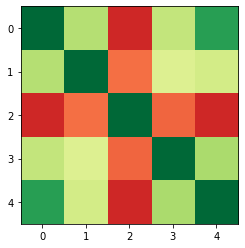

In [51]:
# The first and last class are highly correlated
corrs=np.corrcoef(logistic.predict_proba(df2[features]).T)
plt.imshow(corrs, vmin=-1, vmax=1, cmap="RdYlGn")
corrs

In [52]:
# Out-of-sample correlation is 3.5%
preds = pd.Series(logistic.predict_proba(df2[features]).dot(logistic.classes_), index=df2.index)
numerai_score(df2[target], preds)

0.03504082804703481

In [53]:
# A standard linear model has a slightly lower correlation out-of-sample
linear = linear_model.LinearRegression()
linear.fit(df1[features], df1[target])
linear.score(df2[features], df2[target])
preds = pd.Series(linear.predict(df2[features]), index=df2.index)
numerai_score(df2[target], preds)

0.03469854472021291

## Eras can be more or less applicable to other eras
You can test this be splitting the eras into blocks of 15, training on each block, and evaluating on each other block.

In [54]:
# convert the subsampled era labels to continuous integers
eras_sub = (eras-1)//4

In [55]:
eras15 = (eras_sub // 15) * 15
eras15.value_counts()

60     71000
105    69251
120    67610
45     67268
90     66300
75     61933
30     61333
15     54214
0      42920
135    42282
Name: erano, dtype: int64

In [56]:
results15 = []
for train_era, tdf in df.groupby(eras15):
    print(train_era)
    model = linear_model.LinearRegression()
    model.fit(tdf[features], tdf[target])
    for test_era, tdf in df.groupby(eras15):
        results15.append([
            train_era,
            test_era,
            correlation_score(tdf[target], model.predict(tdf[features]))
        ])

0
15
30
45
60
75
90
105
120
135


In [57]:
results_df = pd.DataFrame(
    results15,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df

test_era,0,15,30,45,60,75,90,105,120,135
train_era,,,,,,,,,,
0,0.194921,0.043216,0.030027,0.016123,0.009126,0.023706,0.033789,0.022836,0.024734,0.020147
15,0.046587,0.170537,0.029796,-0.007569,0.002888,0.001372,0.000648,0.001539,-0.007086,-0.005150
30,0.039467,0.032860,0.156099,0.002623,0.003846,0.006211,0.005686,-0.001824,-0.000756,-0.002574
45,0.023706,0.030027,0.035148,0.148862,0.010267,0.021071,0.027580,0.015904,0.031235,0.023599
60,0.012483,0.006499,0.009025,0.016631,0.149721,0.019196,0.010640,0.013178,0.010896,0.011191
75,0.025632,0.018699,0.031269,0.016043,0.018465,0.166712,0.026355,0.017058,0.021476,0.011319
90,0.044772,0.025483,0.024666,0.024288,0.005159,0.029021,0.153414,0.024905,0.021045,0.016773
105,0.029213,0.027908,0.018279,0.012079,0.008206,0.016061,0.027251,0.143886,0.023365,0.009489
120,0.033693,0.036589,0.018515,0.030186,0.007597,0.026739,0.023073,0.028707,0.144769,0.030703


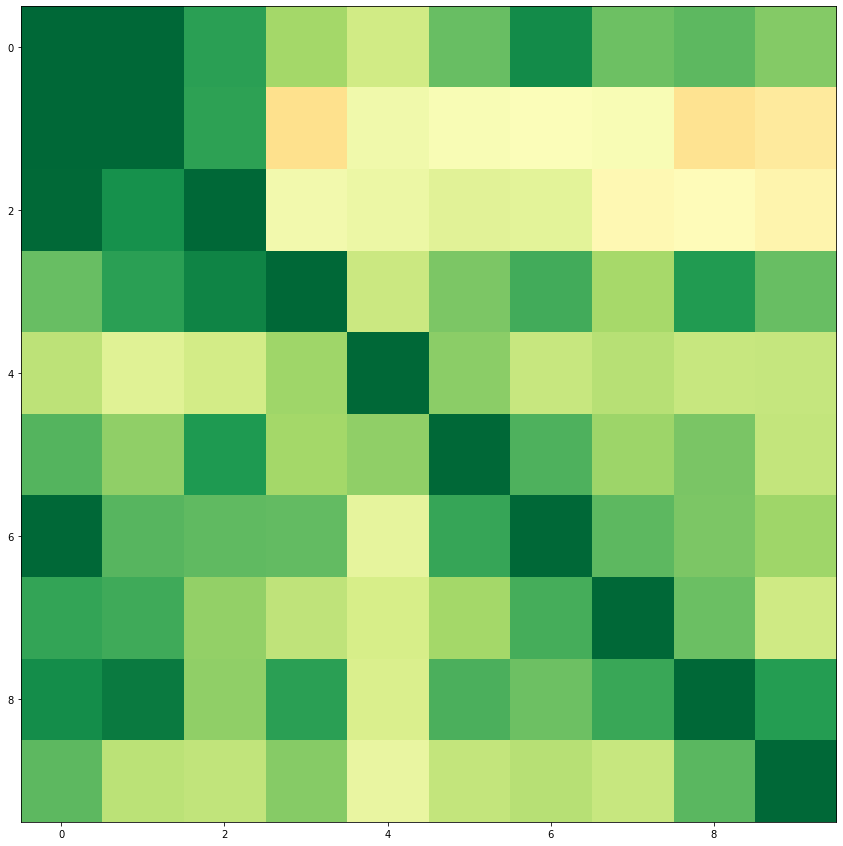

In [58]:
# Each row here is the training block of eras, each column is a testing block of eras.
# Note that there is a period in the early groups that does not seem to be relevant to other eras, and the
# overall performance seems to decrease a bit over time.
plt.figure(figsize=(15,15))
plt.imshow(results_df, vmin=-0.04, vmax=0.04, cmap="RdYlGn")

Here is an advanced paper that talks about generalization.
Eras can be thought about in the same way that "distributions" or "environments" are talked about here
https://arxiv.org/pdf/1907.02893.pdf

## Gotcha: Since the signal-to-noise ratio is so low, models can take many more iterations than expected, and have scarily high in-sample performance

In [59]:
def our_score(preds, dtrain):
    return "score", -np.corrcoef(preds, dtrain.get_label())[0,1], False

df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [60]:
dtrain = lightgbm.Dataset(df1[features], df1[target])
dtest = lightgbm.Dataset(df2[features], df2[target])
dall = lightgbm.Dataset(df[features], df[target])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.395800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5250
[LightGBM] [Info] Number of data points in the train set: 305247, number of used features: 1050
[LightGBM] [Info] Start training from score 0.499998
[20]	train's l2: 0.0498386	train's score: -0.0696572	test's l2: 0.0499211	test's score: -0.042272
[40]	train's l2: 0.0497466	train's score: -0.0845498	test's l2: 0.0499021	test's score: -0.0449487
[60]	train's l2: 0.0496736	train's score: -0.0950992	test's l2: 0.049894	test's score: -0.0462429
[80]	train's l2: 0.0496094	train's score: -0.103748	test's l2: 0.0498883	test's score: -0.0474028
[100]	train's l2: 0.0495503	train's score: -0.111415	test's l2: 0.049883	test's score: -0.0485958
[120]	train's l2: 0.0494963	train's score: -0.118318	test's l2: 0.0498832	test's score: -0.0487773
[140]	train's l2: 0.0494427	train's score: -0.124419	test's l2

<AxesSubplot:>

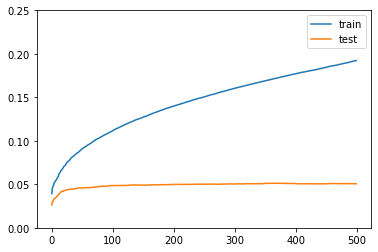

In [61]:
param = {
    'max_depth':3,
    'eta':0.1,
    'objective':'regression',
    'metric':'mse',
    'nthread': -1,
}
evals_result = {}
bst = lightgbm.train(
    params=param,
    train_set=dtrain,
    feval=our_score,
    num_boost_round=500,
    valid_sets=[dtrain, dtest],
    valid_names=['train', 'test'],
    evals_result=evals_result,
    verbose_eval=20,
)

(-pd.DataFrame({k: v['score'] for k,v in evals_result.items()})).plot(ylim=[0,0.25])

# The results are sensitive to the choice of parameters, which should be picked through cross-validation

In [62]:
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [63]:
models = [
    linear_model.LinearRegression(),
] + [
    linear_model.ElasticNet(alpha=alpha)
    for alpha in [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00005, 0.00002, 0.00001]
] + [
    lightgbm.LGBMRegressor(n_jobs=-1),
    lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000, max_depth=5),
    lightgbm.LGBMRegressor(n_jobs=-1, colsample_bytree=0.1, learning_rate=0.001, n_estimators=10000, max_depth=5),
]

In [64]:
for model in models:
    print(" -- ", model)   
    model.fit(df1[features], df1[target])
    outsample = numerai_score(df2[target], pd.Series(model.predict(df2[features]), index=df2.index))
    insample = numerai_score(df1[target], pd.Series(model.predict(df1[features]), index=df1.index))
    print(
        f"outsample: {outsample}, insample: {insample}"
    )
    print()

 --  LinearRegression()
outsample: 0.03449532642406725, insample: 0.08811577962731876

 --  ElasticNet(alpha=0.01)
outsample: -0.0005817296572705758, insample: 0.0011047675627246087

 --  ElasticNet(alpha=0.005)
outsample: -0.0005817296572705758, insample: 0.0011047675627246087

 --  ElasticNet(alpha=0.002)
outsample: 0.028356554996391864, insample: 0.036860395887039446

 --  ElasticNet(alpha=0.001)
outsample: 0.03991189570044001, insample: 0.05365003421490132

 --  ElasticNet(alpha=0.0005)
outsample: 0.04275518297522411, insample: 0.06223910243312713

 --  ElasticNet(alpha=0.0002)
outsample: 0.04408886141392253, insample: 0.07101617648855875

 --  ElasticNet(alpha=0.0001)
outsample: 0.042497050882822206, insample: 0.07683662591705001

 --  ElasticNet(alpha=5e-05)
outsample: 0.04031370910547076, insample: 0.0826422949678376

 --  ElasticNet(alpha=2e-05)


/home/michael/anaconda3/envs/xgb/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.98899841308594, tolerance: 1.5261499881744385
  model = cd_fast.enet_coordinate_descent(


outsample: 0.03723017817413682, insample: 0.08677474150444352

 --  ElasticNet(alpha=1e-05)


/home/michael/anaconda3/envs/xgb/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 759.37939453125, tolerance: 1.5261499881744385
  model = cd_fast.enet_coordinate_descent(


outsample: 0.03591553345108072, insample: 0.08774837309606072

 --  LGBMRegressor()
outsample: 0.04163519344042179, insample: 0.2413164724798182

 --  LGBMRegressor(learning_rate=0.01, n_estimators=1000)
outsample: 0.04716206072784002, insample: 0.27980942641432893

 --  LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, n_estimators=1000)
outsample: 0.049906177599943716, insample: 0.2486898095456977

 --  LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=1000)
outsample: 0.051584782947410084, insample: 0.20542516882601236

 --  LGBMRegressor(colsample_bytree=0.1, learning_rate=0.001, max_depth=5,
              n_estimators=10000)
outsample: 0.05228707325079221, insample: 0.2077346244025685



## Gotcha: Models with large exposures to individual features tend to perform poorly or inconsistently out of sample ## 


In [65]:
import numpy as np
import scipy

In [66]:
# Train a standard xgboost on half the train eras
lgb = lightgbm.LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.01, n_jobs=-1)
lgb.fit(df1[features], df1[target])
lgb_preds = lgb.predict(df2[features])

### Our predictions have correlation < -0.4 and > 0.20 for some single features!
Sure hope those features continue to act as they have in the past!

In [67]:
corr_list = []
for feature in features:
    corr_list.append(np.corrcoef(df2[feature], lgb_preds)[0,1])
corr_series = pd.Series(corr_list, index=features)
corr_series.describe()

count    1050.000000
mean        0.007197
std         0.084903
min        -0.431369
25%        -0.048999
50%         0.008305
75%         0.065700
max         0.195975
dtype: float64

In [68]:
from sklearn.preprocessing import MinMaxScaler
import scipy

def neutralize(df,
               columns,
               neutralizers=None,
               proportion=1.0,
               normalize=True,
               era_col="era"):
    if neutralizers is None:
        neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        print(u, end="\r")
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2).T
        exposures = df_era[neutralizers].values

        scores -= proportion * exposures.dot(
            np.linalg.pinv(exposures.astype(np.float32)).dot(scores.astype(np.float32)))

        scores /= scores.std(ddof=0)

        computed.append(scores)

    return pd.DataFrame(np.concatenate(computed),
                        columns=columns,
                        index=df.index)

In [69]:
df2["preds"] = lgb_preds
df2["preds_neutralized"] = neutralize(df2, 
                                      columns=["preds"], 
                                      neutralizers=features, 
                                      proportion=0.5, # neutralize by 50% within each era
                                      normalize=True,
                                      era_col='era') 

scaler = MinMaxScaler()
df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]]) # transform back to 0-1

<ipython-input-69-4aa87b479082>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds"] = lgb_preds


<ipython-input-69-4aa87b479082>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized"] = neutralize(df2,
<ipython-input-69-4aa87b479082>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]]) # transform back to 0-1


### Now our single feature exposures are much smaller

In [70]:
corr_list2 = []
for feature in features:
    corr_list2.append(np.corrcoef(df2[feature], df2["preds_neutralized"])[0,1])
corr_series2 = pd.Series(corr_list2, index=features)

In [71]:
corr_series2.describe()

count    1050.000000
mean        0.005275
std         0.062161
min        -0.314072
25%        -0.035640
50%         0.006457
75%         0.047849
max         0.144363
dtype: float64

### Our overall score goes down, but the scores are more consistent than before. This leads to a higher sharpe

In [72]:
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized"], d[target])[0,1])

print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")

score for high feature exposure: 0.05233661570835508
score for balanced feature expo: 0.04681538564864233
std for high feature exposure: 0.022859528419203096
std for balanced feature expo: 0.019806139929550184
sharpe for high feature exposure: 2.2894879871795526
sharpe for balanced feature expo: 2.3636804453145936


In [73]:
balanced_scores_per_era.describe()

count    67.000000
mean      0.046815
std       0.019956
min       0.002495
25%       0.032911
50%       0.047356
75%       0.058174
max       0.105836
dtype: float64

In [74]:
unbalanced_scores_per_era.describe()

count    67.000000
mean      0.052337
std       0.023032
min       0.004386
25%       0.035233
50%       0.055631
75%       0.065317
max       0.116914
dtype: float64

## We can also try to be more clever about what features we neutralize
### The "riskiest" features are the features the predictions are most exposed to that also have the highest volatility 

In [75]:
# compute feature correlations with target on the first half data
all_feature_corrs = df1.groupby('era').apply(lambda d: d[features].corrwith(d[target]))
# compute the volatility of the feature correlations
feature_corr_volatility = all_feature_corrs.std()

In [76]:
# calculate the feature exposures of the predictions
feature_exposure_list = []
for feature in features:
    feature_exposure_list.append(np.corrcoef(df2[feature], lgb_preds)[0,1])
feature_exposure_list = pd.Series(feature_exposure_list, index=features)

In [77]:
# get list of 100 riskiest features
riskiest_features = (feature_exposure_list.abs()*feature_corr_volatility).sort_values()[-100:].index.tolist()

In [78]:
# 50% neutralize to the riskiest features
df2["preds_neutralized_riskiest_100"] = neutralize(df2, 
                                                  columns=["preds"], 
                                                  neutralizers=riskiest_features, 
                                                  proportion=0.5, # 50% neutralize only those 100 features
                                                  normalize=True, 
                                                  era_col='era')

scaler = MinMaxScaler()
df2["preds_neutralized_riskiest_100"] = scaler.fit_transform(df2[["preds_neutralized_riskiest_100"]]) # transform back to 0-1

<ipython-input-78-a2ec8b9e6f35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized_riskiest_100"] = neutralize(df2,
<ipython-input-78-a2ec8b9e6f35>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized_riskiest_100"] = scaler.fit_transform(df2[["preds_neutralized_riskiest_100"]]) # transform back to 0-1


### The score goes down less and the sharpe goes up more than 50% neutralizing all the features

In [79]:
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized_riskiest_100"], d[target])[0,1])

print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")

score for high feature exposure: 0.05233661570835508
score for balanced feature expo: 0.04784620200240574
std for high feature exposure: 0.022859528419203096
std for balanced feature expo: 0.01865889557683214
sharpe for high feature exposure: 2.2894879871795526
sharpe for balanced feature expo: 2.5642569146382965


### Interestingly, the maximal feature exposure magnitude is actually lower (~0.28 vs ~0.31) than when 50% neutralizing all features

In [80]:
corr_list3 = []
for feature in features:
    corr_list3.append(np.corrcoef(df2[feature], df2["preds_neutralized_riskiest_100"])[0,1])
corr_series3 = pd.Series(corr_list3, index=features)
corr_series3.describe()

count    1050.000000
mean        0.010188
std         0.058860
min        -0.269052
25%        -0.029323
50%         0.012539
75%         0.050637
max         0.137796
dtype: float64

In [81]:
corr_series3.describe()

count    1050.000000
mean        0.010188
std         0.058860
min        -0.269052
25%        -0.029323
50%         0.012539
75%         0.050637
max         0.137796
dtype: float64

# Training on the alternative targets can result in models with different patterns of feature exposures
## This is a great way to go after MMC and very useful for ensembling

In [82]:
lgb = lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000, max_depth=5)
lgb.fit(df1[features], df1['target'])

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

In [83]:
lgb_jerome = lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000, max_depth=5)
lgb_jerome.fit(df1[features], df1['target_jerome_20'])

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

In [84]:
# The feature importances for each model are about 63% correlated

0.6270969845588339


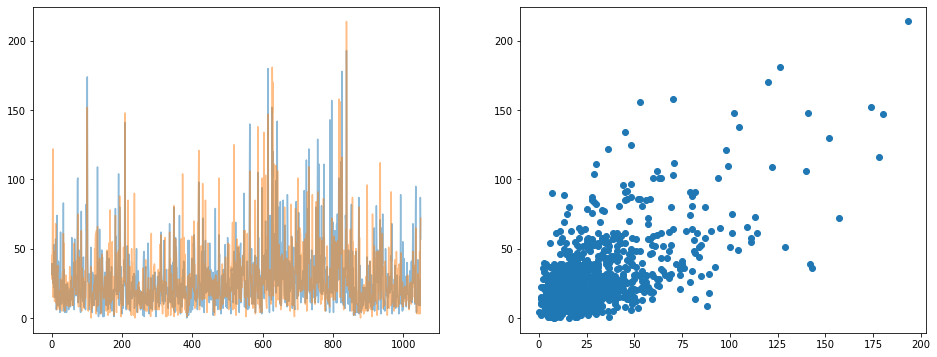

In [85]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(lgb.feature_importances_, alpha=.5)
plt.plot(lgb_jerome.feature_importances_, alpha=.5)
plt.subplot(1,2,2)
plt.scatter(lgb.feature_importances_, lgb_jerome.feature_importances_)

print(np.corrcoef([lgb.feature_importances_, lgb_jerome.feature_importances_])[0,1])

In [86]:
lgb_preds = lgb.predict(df2[features])
lgb_jerome_preds = lgb_jerome.predict(df2[features])

In [87]:
# The predictions are about 75% correlated
np.corrcoef([lgb_preds, lgb_jerome_preds])[0,1]

0.7510865174862386

In [88]:
df2["preds"] = lgb_preds
df2["preds_jerome"] = lgb_jerome_preds

<ipython-input-88-abbdda99d361>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds"] = lgb_preds
<ipython-input-88-abbdda99d361>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_jerome"] = lgb_jerome_preds


In [89]:
# 50% neutralize to riskest features for each model as above
for preds in ["preds", "preds_jerome"]:
    feature_exposure_list = []
    for feature in features:
        feature_exposure_list.append(np.corrcoef(df2[feature], df2[preds])[0,1])
    feature_exposure_list = pd.Series(feature_exposure_list, index=features)

    riskiest_features = (feature_exposure_list.abs()*feature_corr_volatility).sort_values()[-100:].index.tolist()
    
    df2[f"{preds}_neutralized_riskiest_100"] = neutralize(df2, 
                                                  columns=[f"{preds}"], 
                                                  neutralizers=riskiest_features, 
                                                  proportion=0.5, # 50% neutralize only those 100 features
                                                  normalize=True, 
                                                  era_col='era')

<ipython-input-89-867f2bde3bb9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[f"{preds}_neutralized_riskiest_100"] = neutralize(df2,


0573

In [90]:
# create ensemble
df2["preds_ens"] = (df2["preds"] + df2["preds_jerome"])/2

<ipython-input-90-c7a741c556d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_ens"] = (df2["preds"] + df2["preds_jerome"])/2


In [91]:
scores = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
scores_jerome = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_jerome"], d[target])[0,1])

scores_derisked = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized_riskiest_100"], d[target])[0,1])
scores_jerome_derisked = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_jerome_neutralized_riskiest_100"], d[target])[0,1])

scores_ens = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_ens"], d[target])[0,1])

print(f"score for target: {scores.mean()}")
print(f"score for target_jerome: {scores_jerome.mean()}")
print()
print(f"sharpe for target: {scores.mean()/scores.std(ddof=0)}")
print(f"sharpe for target_jerome: {scores_jerome.mean()/scores_jerome.std(ddof=0)}")
print()
print(f"score for target after neutralization: {scores_derisked.mean()}")
print(f"score for target_jerome after neutralization: {scores_jerome_derisked.mean()}")
print()
print(f"sharpe for target after neutralization: {scores_derisked.mean()/scores_derisked.std(ddof=0)}")
print(f"sharpe for target_jerome after neutralization: {scores_jerome_derisked.mean()/scores_jerome_derisked.std(ddof=0)}")
print()
print(f"score for target + target_jerome ensemble: {scores_ens.mean()}")
print(f"sharpe for target + target_jerome ensemble: {scores_ens.mean()/scores_ens.std(ddof=0)}")


score for target: 0.05233661570835508
score for target_jerome: 0.05293083310575564

sharpe for target: 2.2894879871795526
sharpe for target_jerome: 1.9501765858045648

score for target after neutralization: 0.04784620200240574
score for target_jerome after neutralization: 0.050838690600204337

sharpe for target after neutralization: 2.5642569146382965
sharpe for target_jerome after neutralization: 2.2734387549255732

score for target + target_jerome ensemble: 0.05627261521740282
sharpe for target + target_jerome ensemble: 2.1496760967783635


## We see here that the model trained on `target_jerome` actually predicts `target` slightly better than the model trained on `target` (albeit with a lower Sharpe) both before and after neutralization of the riskiest features

In [ ]:
# calculate correlation of neutralized predictions
df2[[f"preds_neutralized_riskiest_100", f"preds_jerome_neutralized_riskiest_100"]].corr()

## Given that the neutralized version trained on `target_jerome` gets slightly better average score, but is only about 67% correlated with the neutralized version trained on `target`, it is an excellent candidate for MMC
## However, ensembling the two neutralized predictions gives a model with the highest average score and a great Sharpe value